In [89]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import ta
from ta import add_all_ta_features
import yfinance as yf
import datetime as dt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, auc, classification_report, confusion_matrix
from skopt import BayesSearchCV
import time
import warnings
import matplotlib.pyplot as plt

In [84]:
random_seed = 2021

warnings.filterwarnings("ignore")

In [67]:
msft = yf.Ticker("MSFT")

history = msft.history(period='Max')
meta_cols = history.columns
history.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2021-09-03,300.989990,302.600006,300.260010,301.140015,14747900,0.0,0.0
2021-09-07,301.010010,301.089996,298.200012,300.179993,17180400,0.0,0.0
2021-09-08,299.779999,300.609985,297.470001,300.209991,15046800,0.0,0.0
2021-09-09,300.820007,302.140015,297.000000,297.250000,19927000,0.0,0.0
2021-09-10,298.420013,299.920013,295.380005,295.709991,19619400,0.0,0.0


In [68]:
ta_df = add_all_ta_features(df=history, open='Open', high='High', low='Low',close='Close',volume='Volume', fillna=True)

C:\Users\LSQ\anaconda3\lib\site-packages\ta\trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
C:\Users\LSQ\anaconda3\lib\site-packages\ta\trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])


In [69]:
ta_df.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits',
       'volume_adi', 'volume_obv', 'volume_cmf', 'volume_fi', 'volume_mfi',
       'volume_em', 'volume_sma_em', 'volume_vpt', 'volume_nvi', 'volume_vwap',
       'volatility_atr', 'volatility_bbm', 'volatility_bbh', 'volatility_bbl',
       'volatility_bbw', 'volatility_bbp', 'volatility_bbhi',
       'volatility_bbli', 'volatility_kcc', 'volatility_kch', 'volatility_kcl',
       'volatility_kcw', 'volatility_kcp', 'volatility_kchi',
       'volatility_kcli', 'volatility_dcl', 'volatility_dch', 'volatility_dcm',
       'volatility_dcw', 'volatility_dcp', 'volatility_ui', 'trend_macd',
       'trend_macd_signal', 'trend_macd_diff', 'trend_sma_fast',
       'trend_sma_slow', 'trend_ema_fast', 'trend_ema_slow', 'trend_adx',
       'trend_adx_pos', 'trend_adx_neg', 'trend_vortex_ind_pos',
       'trend_vortex_ind_neg', 'trend_vortex_ind_diff', 'trend_trix',
       'trend_mass_index', 'trend_cci', 'trend_dpo', 't

In [70]:
feature_cols = [x for x in ta_df.columns if x not in meta_cols]

In [71]:
toSelect = True
lag_length = 7
history_win = 2
forecast_date = "2021-09-03"

## 1. Data Preparation

In [72]:
### create lagged dataset
df_lagged = ta_df.copy()
df_lagged[feature_cols] = df_lagged[feature_cols].apply(lambda x: x.shift(lag_length))
df_lagged['Close_prev'] = df_lagged['Close'].shift(lag_length)

In [73]:
### Include only data in the specified time window
start_date = pd.to_datetime(forecast_date)-pd.DateOffset(years=history_win)
start_date = start_date.strftime("%Y-%m-%d")

df_lagged.reset_index(drop=False, inplace=True)
df_lagged = df_lagged.loc[(df_lagged.Date >= start_date)&(df_lagged.Date <= forecast_date)]
temp_rows = df_lagged.shape[0]
df_lagged.dropna(axis=0, inplace=True)
print(f"number of NA records is {temp_rows - df_lagged.shape[0]}")

number of NA records is 0


In [74]:
### Create target class labels
df_lagged['label'] = np.where(df_lagged['Close'] > df_lagged['Close_prev'], 1,0)   # 1 = Price increase, 0 = Price decrease

### Separate test data
test_data = df_lagged.loc[df_lagged.Date == forecast_date]

## 2. Modelling

In [75]:
### Split train validation/test set
X_train, X_test, y_train, y_test = train_test_split(df_lagged[feature_cols], df_lagged['label'], test_size=0.2, 
                                                    stratify=df_lagged['label'], random_state=random_seed)

print(X_train.shape, X_test.shape)

(405, 83) (102, 83)


#### Feature Selection (optional)

In [78]:
### Feature selection if needed


### Simple training
model_lgb = lgb.LGBMClassifier(random_state=random_seed, n_jobs=-1)
model_lgb.fit(X_train, y_train)
test_preds = model_lgb.predict(X_test)
test_proba = model_lgb.predict_proba(X_test)[:, 1]
test_auc = roc_auc_score(y_test, test_proba)
test_accuracy = accuracy_score(y_test, test_preds)
print(f"Without feature selection: validation AUC is {test_auc} and accuracy is {test_accuracy}")

if toSelect:    
    df_features_impt = pd.DataFrame({"feature":feature_cols,
                                     "scores":model_lgb.feature_importances_}).sort_values("scores", ascending=False)
    
    best_auc = 0
    best_accuracy = 0
    best_features = None
    start_time = time.time()
    for ittr in range(len(df_features_impt.feature)):
        current_set = df_features_impt.feature[:ittr+1]
        model_lgb = lgb.LGBMClassifier(random_state=random_seed, n_jobs=-1)
        model_lgb.fit(X_train[current_set], y_train)
        test_preds = model_lgb.predict(X_test[current_set])
        test_proba = model_lgb.predict_proba(X_test[current_set])[:, 1]
        test_auc = roc_auc_score(y_test, test_proba)
        test_accuracy = accuracy_score(y_test, test_preds)
        if test_auc > best_auc and (test_auc-best_auc) > 0.001:
            best_auc = test_auc
            best_accuracy = test_accuracy
            best_features = current_set.copy()

    print(f"Number of features selected is {len(best_features)} with validation AUC: {best_auc} and accuracy: {best_accuracy}")
    feature_cols = best_features
    end_time = time.time()
    dur = round((end_time-start_time)/60,2)
    print(f"Feature selection duration: {dur} mins")

Without feature selection: validation AUC is 0.8840085287846482 and accuracy is 0.803921568627451
Number of features selected is 69 with validation AUC: 0.9010660980810234 and accuracy: 0.803921568627451
Feature selection duration: 0.09 mins


#### Hyperparameter Tuning

In [80]:
feature_cols

45       trend_mass_index
40          trend_adx_neg
38              trend_adx
47              trend_dpo
32      trend_macd_signal
             ...         
59        trend_aroon_ind
11         volatility_bbm
35         trend_sma_slow
36         trend_ema_fast
51    trend_ichimoku_conv
Name: feature, Length: 69, dtype: object

In [97]:
params_grid = {
    "learning_rate": (0.01, 0.3),
    "n_estimators": (50, 500),
    "max_depth": (2, 7),
    "subsample": (0.8, 1),
    "feature_fraction": (0.8, 1),
    "lambda_l1": (0, 1),
    "lambda_l2": (0, 1) 
}

In [82]:
model_lgb = lgb.LGBMClassifier(random_state=random_seed, n_jobs=-1)

start_time = time.time()
bayes_gs = BayesSearchCV(model_lgb, params_grid, scoring='roc_auc', cv=5, n_iter=50, n_jobs=-1, random_state=random_seed)
bayes_gs.fit(X_train[feature_cols], y_train)
end_time = time.time()
print(f"Hyperparamter Tuning time: {round((end_time-start_time)/60, 2)} mins")

best_estimator = bayes_gs.best_estimator_
best_params = bayes_gs.best_params_

[LightGBM] [Warning] feature_fraction is set=0.9741585456708786, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9741585456708786
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
Hyperparamter Tuning time: 1.89 mins


In [85]:
validation_preds = best_estimator.predict(X_test[feature_cols])
validation_proba = best_estimator.predict_proba(X_test[feature_cols])

print(classification_report(y_test,validation_preds))

              precision    recall  f1-score   support

           0       0.73      0.69      0.71        35
           1       0.84      0.87      0.85        67

    accuracy                           0.80       102
   macro avg       0.78      0.78      0.78       102
weighted avg       0.80      0.80      0.80       102



In [106]:
cm = confusion_matrix(y_test,validation_preds)

In [108]:
cm

array([[24, 11],
       [ 9, 58]], dtype=int64)

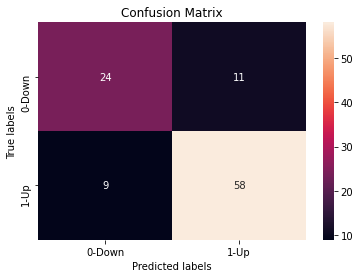

In [110]:
import seaborn as sns  

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['0-Down', '1-Up']); ax.yaxis.set_ticklabels(['0-Down', '1-Up']);

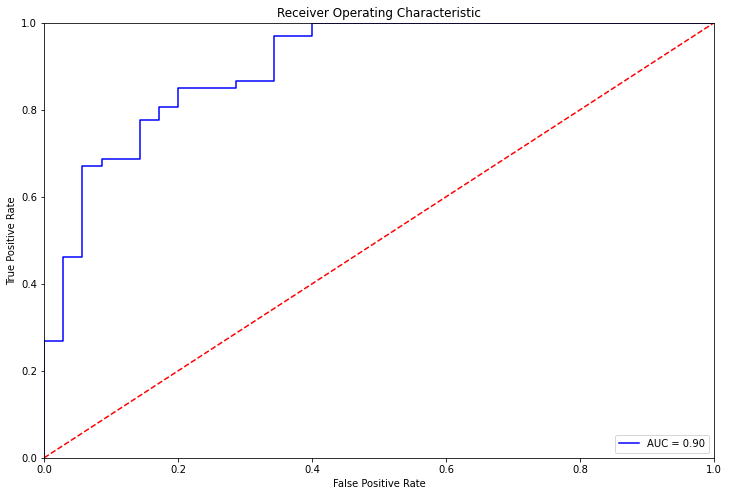

AUC score is 0.90235


In [93]:
fpr, tpr, threshold = roc_curve(y_test, validation_proba[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(12, 8))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

print(f"AUC score is {round(roc_auc_score(y_test, validation_proba[:, 1]), 5)}")

In [98]:
### re-fit to traing and validation data combined
X_train_val = pd.concat([X_train[feature_cols], X_test[feature_cols]], axis=0)
y_train_val = pd.concat([y_train, y_test], axis=0)

final_model = best_estimator
final_model.fit(X_train_val, y_train_val)

LGBMClassifier(feature_fraction=0.9741585456708786, lambda_l1=0, lambda_l2=0,
               learning_rate=0.3, max_depth=7, n_estimators=500,
               random_state=2021)

## 3. Prediction

In [102]:
oos_pred = final_model.predict(test_data[feature_cols])
print(f"True test label is {test_data.label.values[0]} and model prediction is {oos_pred[0]}")

True test label is 0 and model prediction is 0
